# Image Derivatives
This exercise introduces image derivative operators.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from scipy import ndimage


Bad key "text.kerning_factor" on line 4 in
/home/pk/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Some Convenience Functions.

In [2]:
def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1)
    image = ndimage.convolve(image, kernel2)   
    return image

def imread_gray(filename):
    """Read grayscale image from our data directory."""
    return cv2.imread(f'../data/{filename}',
                      cv2.IMREAD_GRAYSCALE).astype(np.float32)

def plot_multiple(images, titles, colormap='gray',
                  max_columns=np.inf, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        
    fig.tight_layout()

In [3]:
# From Question 1: Gaussian Filtering
def gauss(x, sigma):
    return 1.0 / np.sqrt(2.0 * np.pi) / sigma * np.exp(- x**2 / 2.0 / sigma**2)

## Part a
Implement a function for creating a Gaussian derivative filter in 1D according to the following equation

$$
\frac{d}{dx} G = \frac{d}{dx} \frac{1}{\sqrt{2\pi}\sigma} \operatorname{exp}\biggl(-\frac{x^2}{2\sigma^2}\biggr)
               = -\frac{1}{\sqrt{2\pi}\sigma^3}x \operatorname{exp}\biggl(-\frac{x^2}{2\sigma^2}\biggr)
$$

Your function should take a vector of integer values $x$ and the standard deviation ``sigma`` as arguments.

In [4]:
def gaussdx(x, sigma):
    # Your code here
    return -1.0 / np.sqrt(2.0 * np.pi) / (sigma**3)* x * np.exp(- x**2 / 2.0 / sigma**2)

In [5]:
x = np.linspace(-5, 5, 100)
y = gaussdx(x, sigma=1.0)
fig, ax = plt.subplots()
ax.plot(x, y)

<IPython.core.display.Javascript object>

The effect of applying a filter can be studied by observing its so-called *impulse response*.
For this, create a test image in which only the central pixel has a non-zero value (called an *impulse*):

In [6]:
impulse = np.zeros((25, 25), dtype=np.float32)
impulse[12, 12] = 255

Now, create the following 1D filter kernels ``gaussian`` and ``derivative``.

In [7]:
sigma = 6.0
kernel_radius = int(3.0 * sigma)
x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
G = gauss(x, sigma)
D = gaussdx(x, sigma)

What happens when you apply the following filter combinations? 
(Hint: use ``convolve_with_two`` function at the beginning of this notebook.)

- first ``gaussian``, then ``gaussian^T``.
- first ``gaussian``, then ``derivative^T``.
- first ``derivative``, then ``gaussian^T``.
- first ``gaussian^T``, then ``derivative``.
- first ``derivative^T``, then ``gaussian``.

Display the result images with the `plot_multiple` function. Describe your result.

In [8]:
# Modify this
images = [
    impulse,
    convolve_with_two(impulse, G,  G.T),
    convolve_with_two(impulse, G,  D.T),
    convolve_with_two(impulse, D,  G.T),
    convolve_with_two(impulse, G.T,D),
    convolve_with_two(impulse, D.T,G)]

titles = [
    'original',
    'first G, then G^T',
    'first G, then D^T',
    'first D, then G^T',
    'first G^T, then D',
    'first D^T, then G']

plot_multiple(images, titles, max_columns=3)

<IPython.core.display.Javascript object>

## Part b

Use the functions ``gauss`` and ``gaussdx`` directly in order to create a new function ``gauss_deriv`` that returns the 2D Gaussian derivatives of an input image in $x$ and $y$ direction.

In [9]:
def gauss_derivs(image, sigma):
    # x is the size of the Gauss which has to be determined
    # size of the kernel : kernel_size
    # the interval of kernel is in the range of [-kernel_range,kernel_range]
    kernel_range = int(np.round(3*sigma))
    kernel_size = 2*kernel_range + 1
    
    # x : the input for computing Gaussian kernel
    x = np.linspace(-kernel_range, kernel_range, kernel_size, dtype=float)[np.newaxis]

    G = gauss(x, sigma)
    D = gaussdx(x, sigma)
    image_dx = convolve_with_two(image, D,  G.T)
    image_dy = convolve_with_two(image, G,  D.T)
    
    return image_dx, image_dy

Try the function on the given example images and describe your results.

In [10]:
image = imread_gray('tomatoes.png')
grad_dx, grad_dy = gauss_derivs(image, sigma=5.0)
plot_multiple([image, grad_dx, grad_dy], 
              ['Image', 'Derivative in x-direction', 'Derivative in y-direction'])

<IPython.core.display.Javascript object>

In a similar manner, create a new function ``gauss_second_derivs`` that returns the 2D second Gaussian derivatives $\frac{d^2}{dx^2}$, $\frac{d^2}{dx dy}$ and $\frac{d^2}{dy^2}$ of an input image.

In [11]:
def gauss_second_derivs(image, sigma):
        # x is the size of the Gauss which has to be determined
    # size of the kernel : kernel_size
    # the interval of kernel is in the range of [-kernel_range,kernel_range]
    kernel_range = int(np.round(3*sigma))
    kernel_size = 2*kernel_range + 1
    
    # x : the input for computing Gaussian kernel
    x = np.linspace(-kernel_range, kernel_range, kernel_size, dtype=float)[np.newaxis]

    G = gauss(x, sigma)
    D = gaussdx(x, sigma)
    
    image_dx, image_dy = gauss_derivs(image, sigma)
    
    image_dxx = convolve_with_two(image_dx, D,  G.T)
    
    image_dxy = convolve_with_two(image_dx, G,  D.T)
    
    image_dyy = convolve_with_two(image_dy, G,  D.T)
    
    return image_dxx, image_dxy, image_dyy

Try the function on the given example images and describe your results.

In [12]:
image = imread_gray('coins1.jpg')
grad_dxx, grad_dxy, grad_dyy = gauss_second_derivs(image, sigma=2.0)
plot_multiple([image, grad_dxx, grad_dxy, grad_dyy], 
              ['Image', 'Dxx', 'Dxy','Dyy'])

<IPython.core.display.Javascript object>

In [13]:
image = imread_gray('circuit.png')
grad_dxx, grad_dxy, grad_dyy = gauss_second_derivs(image, sigma=2.0)
plot_multiple([image, grad_dxx, grad_dxy, grad_dyy], 
              ['Image', 'Dxx', 'Dxy','Dyy'])

<IPython.core.display.Javascript object>

**Briefly describe the results here:**

----

## Part c
Create a new function ``image_gradients_polar`` that returns two images with the magnitude and orientation of the gradient for each pixel of the input image.

In [14]:
def image_gradients_polar(image, sigma):
    
    image_dx, image_dy = gauss_derivs(image, sigma)
    
    magnitude = np.sqrt(image_dx*image_dx+image_dy*image_dy)
    # np.arctan2 has better  functionality than np.arctan because
    # np.arctan2 specifies the angle based on the quarter better
    direction = np.arctan2(image_dy,image_dx)

    return magnitude, direction

Try the function on the given example images and describe your results.

In [15]:
image = imread_gray('coins1.jpg')
grad_mag, grad_dir = image_gradients_polar(image, sigma=2.0)

# Note: the twilight colormap only works since Matplotlib 3.0, use 'gray' in earlier versions.
plot_multiple([image, grad_mag, grad_dir], 
              ['Image', 'Magnitude', 'Direction'], 
              colormap=['gray', 'gray', 'twilight']) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


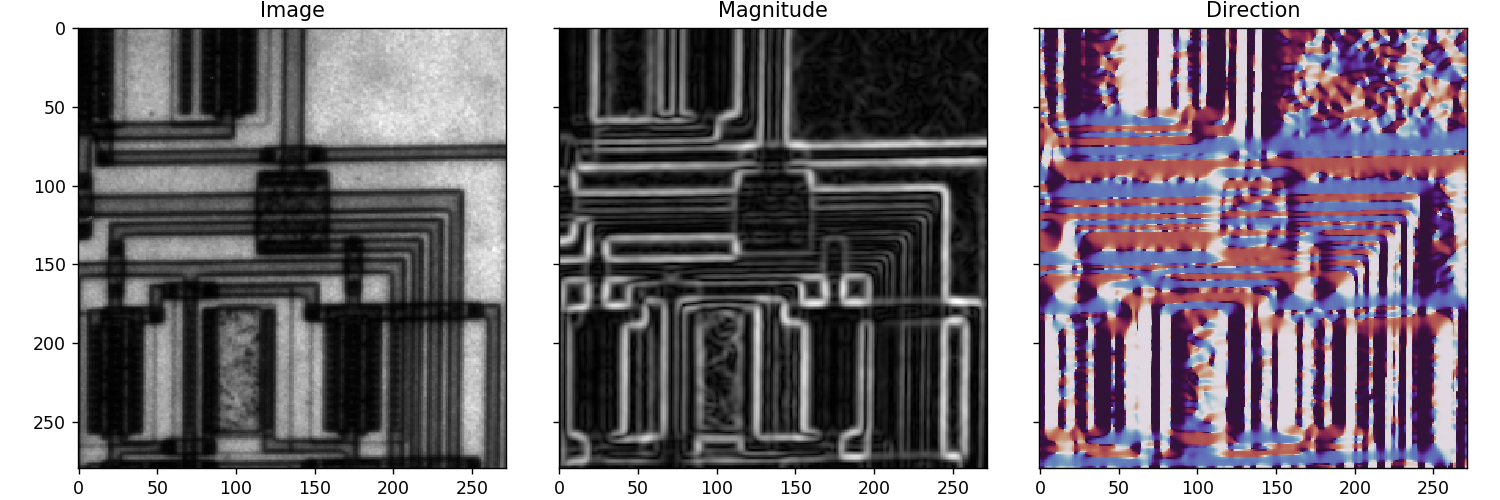

In [16]:
image = imread_gray('circuit.png')
grad_mag, grad_theta = image_gradients_polar(image, sigma=2.0)
plot_multiple([image, grad_mag, grad_theta], 
              ['Image', 'Magnitude', 'Direction'],
              colormap=['gray', 'gray', 'twilight'])

**Briefly describe your results here:**
    
----

## Part d
Create a new function ``laplace`` that returns an image with the Laplacian-of-Gaussian for each pixel of the input image.

In [17]:
def laplace(image, sigma):
    grad_dxx, grad_dxy, grad_dyy = gauss_second_derivs(image, sigma)
    
    lap = grad_dxx + grad_dyy
    
    return lap

Try the function on the given example images and describe your results.

<IPython.core.display.Javascript object>


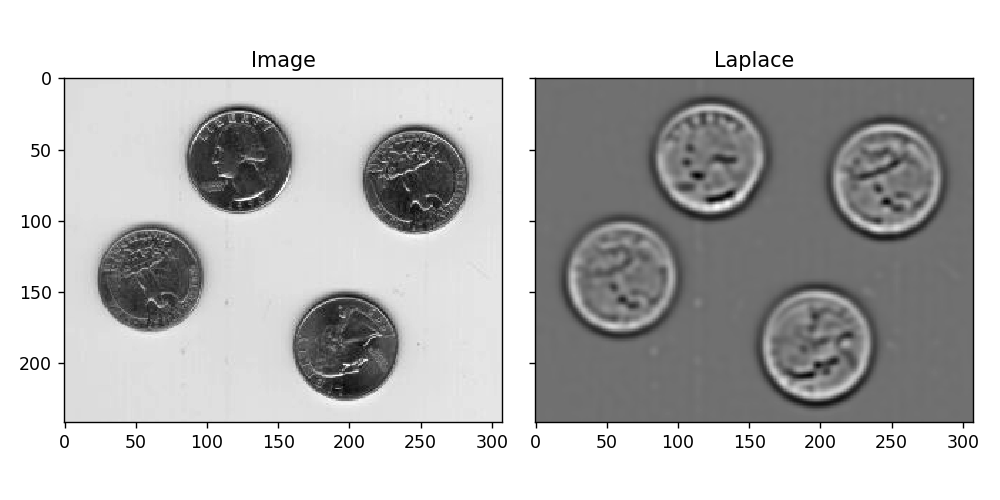

In [18]:
image = imread_gray('coins1.jpg')
lap = laplace(image, sigma=2.0)
plot_multiple([image, lap], ['Image', 'Laplace'])

<IPython.core.display.Javascript object>


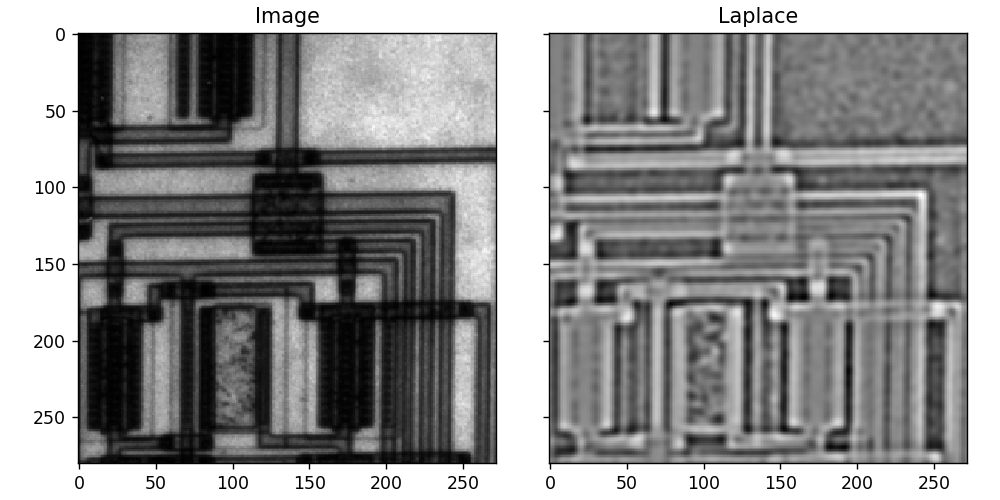

In [19]:
image = imread_gray('circuit.png')
lap = laplace(image, sigma=2.0)
plot_multiple([image, lap], ['Image', 'Laplace'])

**Briefly describe your results here:**
    
----

In [21]:
lap.shape

(280, 272)

In [20]:
import sympy as sym
x = sym.Symbol('x')
s = sym.Symbol('s')

GAUSSIAN = sym.exp(-x**2/s**2/2)/(sym.sqrt(2*sym.pi)*s)
First_Deriv = sym.diff(GAUS, x)
Second_Deriv() = sym.diff(First_Deriv, x)
print(Second_Deriv)

SyntaxError: can't assign to function call (<ipython-input-20-40a4deff9206>, line 7)

In [ ]:
Second_Deriv()